In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 
%load_ext tensorboard

In [2]:
import tensorflow as tf 
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import tensorflow.keras.backend as kb
import yaml
import datetime
import glob

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [5]:
from HelperFn.ExpData_Generator import TrainingGenerator
from HelperFn.ExpData_Generator import EvalTestGenerator
from HelperFn.utils import Params
from sklearn.metrics import r2_score
# from vis.visualization import visualize_saliency, visualize_cam, overlay

In [15]:
Data_set_name = 'experimental_fault/'
mini_EXP_name = 'final_param'

MODEL_DIR = 'experiments/' + Data_set_name
exp_folder_path = MODEL_DIR + '/' + mini_EXP_name


DATA_DIR = '../processed_input_data/' + Data_set_name
NPY_FOLDER = 'slice_npy/'
ML_EXP = 'split_master/'
Train_Master = 'train_master.txt'
Eval_Master = 'eval_master.txt'
Test_Master = 'test_master.txt'
json_path = os.path.join(exp_folder_path, 'params.json')

In [7]:
params = Params(json_path)

input_slice_shape = (128,64,1)
batch_size = params.batch_size
MMT = params.bn_momentum
LR = params.learning_rate
num_channels = params.num_channels
EPOCH = params.num_epochs

In [8]:
## define model
model = Sequential()
model.add(layers.Input(shape=input_slice_shape))
# channels = [num_channels, num_channels * 2,num_channels * 4 ]
channels = [num_channels, num_channels * 2]
for c in channels:
    model.add(layers.Conv2D(c, 3, padding='same'))
    model.add(layers.Conv2D(c, 3, dilation_rate = 2, padding='same'))
    model.add(layers.BatchNormalization(momentum=MMT))
    model.add(layers.Activation(activation='relu'))
    model.add(layers.MaxPooling2D(2))
model.add(layers.Flatten())
model.add(layers.Dense(channels[-1]))
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization(momentum=MMT))
model.add(layers.Dense(1, activation='relu'))
#summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 64, 4)        40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 64, 4)        148       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 4)        16        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 4)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 32, 8)         296       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 32, 8)         5

In [11]:
def MSE_wSD_loss(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    mse = tf.keras.losses.MeanSquaredError()
    return mse(Y_true[:, 0], KE_pred)/((Y_true[:, 1])**2+1e-5)

def custom_accuracy_2SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),2*SD_true), dtype = "float32"))
    return C_accuracy 

In [12]:
# compile the model
opt = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=opt, loss = MSE_wSD_loss, 
              metrics=['mse', custom_accuracy_2SD])

In [13]:
filepath = exp_folder_path + "/weights-improvement-{epoch:02d}-{val_custom_accuracy_2SD:.2f}.hdf5"
callbacks = [
#     tf.keras.callbacks.TensorBoard(log_dir='logs'),
#     tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.000001,
#                                      patience=5,mode='min'),
    tf.keras.callbacks.ModelCheckpoint(
        filepath, monitor ='val_loss', verbose=1,
        save_best_only=True, mode= 'min')
]

In [16]:
training_generator = TrainingGenerator(ML_EXP, NPY_FOLDER, Train_Master, batch_size = batch_size, data_dir=DATA_DIR)
validation_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, batch_size = batch_size, data_dir=DATA_DIR)

8000
8000
shuffling
3063
3063


In [17]:
# configure early stopping
# fit the model
history = model.fit(x=training_generator, epochs=EPOCH,
                    validation_data=validation_generator, 
                    callbacks = callbacks,
                    use_multiprocessing=False)

Epoch 1/2
31/31 [==============================] - ETA: 0s - batch: 15.0000 - size: 256.0000 - loss: 111.4854 - mse: 0.3030 - custom_accuracy_2SD: 0.2330WARNING:tensorflow:From /Users/guest007/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.

Epoch 00001: val_loss improved from inf to 36.93871, saving model to experiments/experimental_fault//final_param/weights-improvement-01-0.39.hdf5
31/31 [==============================] - 28s 889ms/step - batch: 15.0000 - size: 256.0000 - loss: 111.4854 - mse: 0.3030 - custom_accuracy_2SD: 0.2330 - val_loss: 36.9387 - val_mse: 0.3805 - val_custom_accuracy_2SD: 0.3913
Epoch 2/2
31/31 [==============================] - ETA: 0s - batch: 15.0000 - size: 256.0000 - loss:

In [18]:
history.__dict__

{'validation_data': None,
 'model': <tensorflow.python.keras.engine.sequential.Sequential at 0x7f92ed704bb0>,
 '_chief_worker_only': None,
 '_supports_tf_logs': False,
 'history': {'loss': [111.48540767546623, 59.59384278328188],
  'mse': [0.3029753, 0.21669851],
  'custom_accuracy_2SD': [0.23298891, 0.36050907],
  'val_loss': [36.938709865916856, 13.858075878836893],
  'val_mse': [0.3805056, 0.21613501],
  'val_custom_accuracy_2SD': [0.39133522, 0.5213068]},
 'params': {'batch_size': None,
  'epochs': 2,
  'steps': 31,
  'samples': 31,
  'verbose': 1,
  'do_validation': True,
  'metrics': ['loss',
   'mse',
   'custom_accuracy_2SD',
   'val_loss',
   'val_mse',
   'val_custom_accuracy_2SD']},
 'epoch': [0, 1]}

In [20]:
raw_history = history.history
with open (exp_folder_path + "/raw_history.yaml", "w") as filehandle:
    yaml.dump(history.history,filehandle)

In [21]:
with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
    raw_history = yaml.load(filehandle2, Loader = yaml.Loader)

In [22]:
val_loss = raw_history['val_loss']
train_accuracy = raw_history['custom_accuracy_2SD']
val_accuracy = raw_history['val_custom_accuracy_2SD']
best_model_EPOCH = val_loss.index(min(val_loss)) + 1 
selected_history = {}
selected_history['Bmodel_EPOCH'] = best_model_EPOCH
selected_history['min_val_loss'] =  np.round(min(val_loss),4)
selected_history['max_train_accuracy'] =  np.round(max(train_accuracy),4)
selected_history['max_val_accuracy'] =  np.round(max(val_accuracy),4)
selected_history['Bmodel_train_accuracy'] =  np.round(train_accuracy[val_loss.index(min(val_loss))],4)
selected_history['Bmodel_val_accuracy'] = np.round(val_accuracy[val_loss.index(min(val_loss))],4)

In [23]:
selected_history

{'Bmodel_EPOCH': 2,
 'min_val_loss': 13.8581,
 'max_train_accuracy': 0.3605,
 'max_val_accuracy': 0.5213,
 'Bmodel_train_accuracy': 0.3605,
 'Bmodel_val_accuracy': 0.5213}

In [41]:
# EPOCH = 100

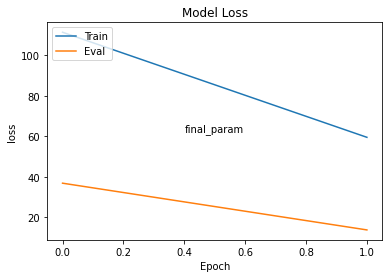

In [24]:
plt.plot(raw_history['loss'][0:EPOCH])
plt.plot(raw_history['val_loss'][0:EPOCH])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path  +'/loss_.png')
plt.show()

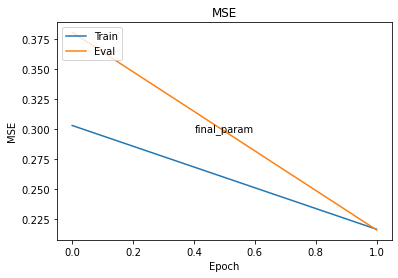

In [25]:
plt.plot(raw_history['mse'][0:EPOCH])
plt.plot(raw_history['val_mse'][0:EPOCH])
plt.title('MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path + '/mse.png')
plt.show()

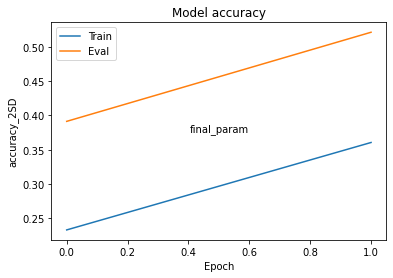

In [26]:
plt.plot(raw_history['custom_accuracy_2SD'][0:EPOCH])
plt.plot(raw_history['val_custom_accuracy_2SD'][0:EPOCH])
plt.title('Model accuracy')
plt.ylabel('accuracy_2SD')
plt.xlabel('Epoch')
plt.text(0.5, 0.5, mini_EXP_name, 
         horizontalalignment = 'center', transform=plt.gca().transAxes)
plt.legend(['Train','Eval'], loc='upper left')
plt.savefig(exp_folder_path + '/custom_accuracy_2SD.png')
plt.show()

In [28]:
files = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
saved_model = []
for file in files:
    print(file.split('/')[-1])
    saved_model.append(file.split('/')[-1])

weights-improvement-01-0.39.hdf5
weights-improvement-02-0.52.hdf5


In [46]:
selectedE = 46
selected_weights = ''
for file in saved_model:
    if file.split('-')[-2][0:2]==str(selectedE):
        selected_weights = file
print (selected_weights)  

weights-improvement-46-0.96.hdf5


In [47]:
filepath = exp_folder_path + '/' + selected_weights 
print(filepath)

experiments/feb2021//LR5e-3_ReducedImAug2/weights-improvement-46-0.96.hdf5


In [48]:
best_model = tf.keras.models.load_model(
    filepath, custom_objects = {"MSE_wSD_loss":MSE_wSD_loss, 
                                "custom_accuracy_2SD": custom_accuracy_2SD,
                                "custom_accuracy_SD": custom_accuracy_SD,
                                "custom_accuracy_avSD": custom_accuracy_avSD})
# best_model = tf.keras.models.load_model(filepath)
# best_model = tf.keras.models.load_model(filepath, custom_objects={"MSE_wSD_loss":MSE_wSD_loss})
# best_model = tf.keras.models.load_model(filepath)

In [49]:
#apply best model to three subset of data

##Training
train_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Train_Master, 
                                       batch_size = batch_size, 
                                       data_dir=DATA_DIR, shuffle = False)
train_label = np.hstack([batch[1][:,0] for batch in train_generator])
train_SD = np.hstack([batch[1][:,1] for batch in train_generator])
train_pred = best_model.predict(x=train_generator)

##Validation
eval_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, 
                                         batch_size = batch_size, 
                                         data_dir=DATA_DIR, shuffle = False)
eval_label = np.hstack([batch[1][:,0] for batch in eval_generator])
eval_SD = np.hstack([batch[1][:,1] for batch in eval_generator])
eval_pred = best_model.predict(x=eval_generator)

##Testing
test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Test_Master, 
                                   batch_size = batch_size, 
                                   data_dir=DATA_DIR, shuffle = False)
test_label = np.hstack([batch[1][:,0] for batch in test_generator])
test_SD = np.hstack([batch[1][:,1] for batch in test_generator])
test_pred = best_model.predict(x=test_generator)

7997
7997
3067
3067
1530
1530


In [50]:
train_LSP = [train_label,train_SD,train_pred]
eval_LSP = [eval_label,eval_SD,eval_pred]
test_LSP = [test_label,test_SD,test_pred]
generator_LSP = [train_LSP,eval_LSP,test_LSP]

In [51]:
def plotting_with_TS_V(generator_LSP, mode, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,12.5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
#         if len(pred) == len(label):
#             print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        

        ax.plot(pred, label,'o', label=f'Correct')
        ax.plot(pred[idx], label[idx], 'ro', label=f'Incorrect')
        ax.plot([0, 1], [0, 1], 'k', alpha=0.2)
        ax.set_title(str(m), fontsize = 24)
        text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 12,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_ylabel('Truth', fontsize =18)
    axs[2].set_xlabel('Prediction', fontsize = 18)

    plt.tight_layout()
    plt.show

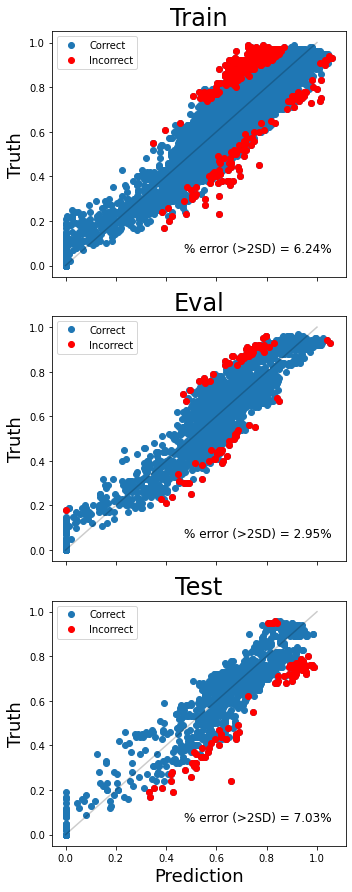

In [52]:
plotting_with_TS_V(generator_LSP, ['Train', 'Eval', 'Test'], selected_EP = selectedE)